# Wildfire

In [14]:
import os, sys
import rasterio
from rasterio import features
from osgeo import gdal
from matplotlib import pyplot
import numpy as np
from osgeo import ogr
import fiona

In [2]:
work_dir = "./data/"
image = os.path.join(work_dir, "LWIR_QuickMosaic_16-bit_9327.tiff")

In [3]:
dataset = rasterio.open(image)

## Printing image metadata

In [5]:
print(f'Name of image: {dataset.name}')
print(f'Mode of image: {dataset.mode}')
print(f'Width of image: {dataset.width}')
print(f'Height of image: {dataset.height}')
print(f'Bounding Box of image: {dataset.bounds}')
print(f'CRS of image: {dataset.crs}')
print(f'Indexes of image: {dataset.indexes}')
print(f'DType of image: {dataset.dtypes[0]}')

Name of image: ./data/LWIR_QuickMosaic_16-bit_9327.tiff
Mode of image: r
Width of image: 5184
Height of image: 12800
Bounding Box of image: BoundingBox(left=-122.446287, bottom=41.39167100000001, right=-122.35966, top=41.553101000000005)
CRS of image: EPSG:4326
Indexes of image: (1,)
DType of image: uint16


In [6]:
band1 = dataset.read(1)
band1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

## Visualizing image

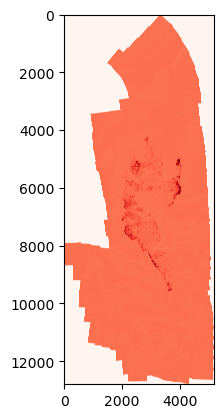

In [27]:
pyplot.imshow(band1, cmap='Reds')
pyplot.show()

## Classification

In [30]:
print(f'Band1 mean: {np.mean(band1)}')
print(f'Band1 max: {np.amax(band1)}')

Band1 mean: 21062.48074881848
Band1 max: 65535


In [7]:
fire_treshold = 35000

In [8]:
raster_classify = np.where(band1 > fire_treshold, 1, 0)

## Saving new raster

In [9]:
with rasterio.open(
    './data/LWIR_QuickMosaic_9327_classified.tif',
    'w',
    driver='GTiff',
    height=dataset.height,
    width=dataset.width,
    count=1,
    dtype='uint8',
    crs=dataset.crs,
) as dst:
    dst.write(raster_classify, 1)

c:\Users\arno\anaconda3\envs\wildfire\lib\site-packages\rasterio\__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


In [10]:
dst.close()

In [11]:
image_clas = rasterio.open('./data/LWIR_QuickMosaic_9327_classified.tif', mode='r')

c:\Users\arno\anaconda3\envs\wildfire\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [12]:
band_clas = image_clas.read(1)

## Exporting raster to polygon

https://rasterio.readthedocs.io/en/latest/cli.html#shapes

In [84]:
os.system('rio shapes data/LWIR_QuickMosaic_9327_classified.tif --bidx 1 --precision 1 --collection > data/raster_clas.geojson')

0

https://snyk.io/advisor/python/rasterio/functions/rasterio.features.shapes

https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html

## 

In [20]:
# Convert the classified raster to polygons
shapes = features.shapes(band_clas) #, transform=raster_meta['transform'])

# Write the polygons to a shapefile
with fiona.open('./data/HeatPoly.shp', 'w', 'ESRI Shapefile', crs=fiona.crs.from_epsg(4326), schema={'geometry': 'Polygon', 'properties': {}}) as shapefile:
    for shape in shapes:
        value = shape[1]
        if value > 0:
            feature = {'geometry': shape[0], 'properties': {}}
            shapefile.write(feature)
